In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
from tqdm import tqdm

# (A) Set-up parameters

In [2]:
# paths
dir_backgrounds = "./backgrounds/treebark_cropped15/" # path to background images
mask_name = './mask_triangle.tiff' # path to mask
dir_output = './output/' # path to output (will be created if it does not exist)

# image variables
num_sample_per_im = 32 # number of background samples per image
imsize = 256 # crop size from the background image
target_y = int(imsize/8) # 32
target_x = int(imsize/4) # 64

resize_factor = 1 # resize background image before cropping
ts = 10000 # number of training steps
batch_size = 16 # batch size
n_gpu = 1 # number of GPUs to use

# discriminator variables
depth_DM = 64
lr_DM = 0.0002 # learning rate of disciminator network
drop_DM = 0.5 # dropout rate in discriminator network
depth_AM = 4
# adversarial variables
lr_AM = 0.0001 # learning rate of adversarial network
drop_AM = 0.5 # dropout rate in adversarial network
rand_input = 100 # number of random numbers for input

# output image variables
si = 500 # save interval
n_plot_samples = 16 # number of image samples to print
save_name_image = 'camo1_' # prefix for images with targets and backgrounds
save_name_target = 'target1_' # prefix for images of targets

# (B) Generating samples as training set

## $\color{purple}{\text{(1) Process the mask (trangle)}}$

In [3]:
im_backgrounds = os.listdir(dir_backgrounds)
mask = cv2.imread(mask_name) # shape (32, 64, 3)
mask = cv2.resize(mask, (target_x, target_y), interpolation = cv2.INTER_NEAREST)

# Code below makes the mask contains only 1 for area of trangle, 0 for other places
# mask_inv contains only 0 for area of trangle, 1 for other places 

mask = np.float32(mask/255)
mask_inv = 1 - mask

## $\color{purple}{\text{(2) Declare data container}}$

In [4]:
# mask_holder, samples_empty is 0 (or random number, doesn't matter) everywhere

mask_holder = np.zeros((len(im_backgrounds*num_sample_per_im),mask.shape[0],mask.shape[1],3))
samples_container = np.zeros((len(im_backgrounds*num_sample_per_im),imsize,imsize,3))

In [5]:
print("mask shape:", end = " ")
print(mask.shape)
print("\nmask_holder shape:", end = " ")
print(mask_holder.shape)
print("\nsamples_container shape:", end = " ")
print(samples_container.shape)
print("\nThe first element in im_backgrounds is a string :", end = " ")
print(im_backgrounds[0])

mask shape: (32, 64, 3)

mask_holder shape: (3200, 32, 64, 3)

samples_container shape: (3200, 256, 256, 3)

The first element in im_backgrounds is a string : DSC_4204_cropped_r15.png


## $\color{purple}{\text{(3)  Randomly extracting crop image from tree image}}$

In [6]:
counter = 0
for index in range(len(im_backgrounds)):
    # the background image with arbitrary size
    path_background_image = dir_backgrounds + im_backgrounds[index]
    
    im = cv2.imread(path_background_image)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # convert to RGB, reason???
    
    # float32 is used here, you could change it to float64, slower but more accuate
    # im has arbitrary size (???, ???, 3), and entry value is [0,1]
    im = np.float32(im/255)
    if resize_factor != 1:
        # Resizing if needed, x becomes fx(x), y becomes fy(y)
        # Not nessesary since we extract graph from romdom position
        # If you did change the size, make sure it is greater than the crop_size
        im = cv2.resize(im, (0,0), fx = resize_factor, fy = resize_factor)
    for what_ever in range(num_sample_per_im):
        # generate random number from [0, side length - crop image length + 1]
        sample_x = random.randint(0, im.shape[0]-imsize-1)
        sample_y = random.randint(0, im.shape[1]-imsize-1)
        # extract small rectangle crop image
        samples_container[counter,:,:,:] = im[sample_x:sample_x+imsize, sample_y:sample_y+imsize,:]
        mask_holder[counter,:,:,:] = mask
        counter = counter + 1

## $\color{purple}{\text{(4)Load data, and randomly draw results}}$

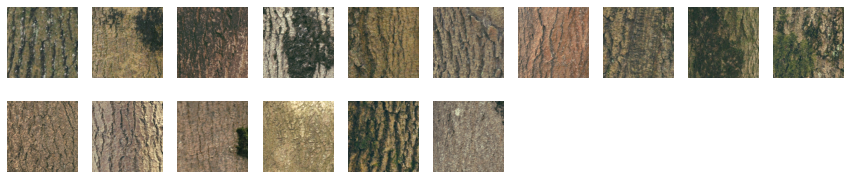

In [7]:
train_dl = torch.utils.data.DataLoader(samples_container, batch_size=batch_size, shuffle=True)

# Draw
batch = next(iter(train_dl))
plt.figure(figsize=(15,17))
for i in range(min(20, batch_size)):
    plt.subplot(10,10,i+1)
    piece = batch[i]
    plt.imshow(piece)
    plt.axis('off')

# (D) GAN network

In [10]:
class gan(nn.Module):
    def __init__(self, samples_container):
        super().__init__()
        self.Z_dim = 128
        self.losses_D = []
        self.losses_G = []
        self.Number_Channel = 1
        self.Number_Feature_Dis = 64
        self.Number_Feature_Gen = 64
        
        self.samples_container = samples_container

        # D: Convolution part of the discriminator
        self.D = nn.Sequential(
            nn.Conv2d(self.Number_Channel, self.Number_Feature_Dis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis) x 14 x 14
            
            nn.Conv2d(self.Number_Feature_Dis, self.Number_Feature_Dis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*2) x 7 x 7
            
            nn.Conv2d(self.Number_Feature_Dis * 2, self.Number_Feature_Dis * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*4) x 4 x 4
            
            nn.Conv2d(self.Number_Feature_Dis * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        # G: Generator, generating size differ from D
        self.G = nn.Sequential(
            
            nn.ConvTranspose2d(self.Z_dim, self.Number_Feature_Gen * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 4),
            nn.ReLU(True),
            # (Number_Feature_Gen*8) x 4 x 4
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 4, self.Number_Feature_Gen * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 2),
            nn.ReLU(True),
            # (Number_Feature_Gen*4) x 8 x 8
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 2, self.Number_Feature_Gen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen),
            nn.ReLU(True),
            # (Number_Feature_Gen*2) x 16 x 16
            
            nn.ConvTranspose2d(self.Number_Feature_Gen, self.Number_Channel, 4, 2, 1, bias=False),
            # 1 * 28 * 28
            
            nn.Tanh()
        )
        self.D.to(device)
        self.G.to(device)
        
        self.Loss_D = nn.BCELoss()
        self.Loss_G = nn.BCELoss()
        self.G.apply(weights_init)
        self.D.apply(weights_init)
        self.to(device)
                
    def forward(self, x):
        return self.discriminate(x)
    
    def discriminate(self, x):
        '''
         y = net.discriminate(x)
         
         Runs the discriminative network on a batch of inputs.
         
         Inputs:
          x   [D,<input shape>] batch of inputs
              where <input shape> is [1,28,28]
          
         Outputs:
          y   Dx1 batch of outputs
        '''
        #z = self.D(x)
        return self.D(x)
        
    def generate(self, n=1):
        '''
         y = net.generate(n=1)
         
         Generates a batch of n inputs using random latent-vector seeds.
         
         Inputs:
          n   number of inputs to generate
          
         Outputs:
          y   [n,<input shape>] batch of generated inputs
              where <input shape> is [1,28,28]
        '''
        z = torch.randn(n, self.Z_dim, 1, 1, device=device)
        return self.G(z)
    
        
    def learn(self, dl, epochs=10, lr=0.0001):
        optimizerD = torch.optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))
        optimizerG = torch.optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        for epoch in tqdm(range(epochs)):
            for x,t in dl:
                real_data = x.to(device)
                batch_size = real_data.size(0)
                label = torch.full((batch_size,), 1., dtype=torch.float, device=device)
                
                # (1) Update D network
                self.D.zero_grad()
                output = self.D(real_data).view(-1)
                errD_real = self.Loss_D(output, label) # label it as real image
                errD_real.backward()
                
                # generate fake image
                noise = torch.randn(batch_size, self.Z_dim, 1, 1, device=device)
                target = self.G(noise) # 32 * 64 first multiply mask, then padding
                
                padded_target = target  # pad with 0, (32, 64) -> (256, 256)
                # Saver to generate fake batch using random numbers instead of another dataloader
                fake_batch_index = np.random.randint(0, self.samples_container.shape[0], size=batch_size)
                fake_batch = samples_container[fake_batch_index, :, :, :]
                # process here
                
                tlX = int(imsize/2-target_x/2)
                tlY = int(imsize/2-target_y/2)
                fake_batch[:,tlY:tlY+target_y,tlX:tlX+target_x, :] = fake_batch[:,tlY:tlY+target_y,tlX:tlX+target_x, :] * mask_inv
                fake_batch = torch.from_numpy(fake_batch)
                # pad the target with 0
                fake_data = padded_target + fake_batch
                label.fill_(0.) # fake label
                output = self.D(fake_data.detach()).view(-1) 
                
                # Train D with fake image, fake label
                errD_fake = self.Loss_D(output, label)
                errD_fake.backward()
                errD = errD_real + errD_fake
                optimizerD.step()
                
                # Train G
                self.G.zero_grad()        
                label.fill_(1.)  # label real, same fake imgae
                output = self.D(fake_data).view(-1)
                errG = self.Loss_G(output, label)
                errG.backward()
                optimizerG.step()
                
                self.losses_D.append(errD.item())
                self.losses_G.append(errG.item())
        plt.plot(self.losses_D); plt.plot(self.losses_G);
        plt.legend(['Disc.', 'Gen.']);
        plt.xlabel('Epochs'); plt.yscale('log');

In [30]:
fake_batch_index = np.random.randint(0, samples_container.shape[0], size=batch_size)
fake_batch = samples_container[fake_batch_index, :, :, :]
fake_batch = torch.from_numpy(fake_batch)


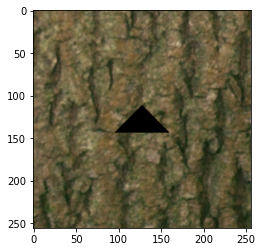

In [15]:
fake_batch.shape

for j in range(0,fake_batch.shape[0]):
                tlX = int(imsize/2-target_x/2)
                tlY = int(imsize/2-target_y/2)
                fake_batch[j,tlY:tlY+target_y,tlX:tlX+target_x, :] = fake_batch[j,tlY:tlY+target_y,tlX:tlX+target_x, :] * mask_inv
plt.imshow(fake_batch[0])    
                
                

In [31]:
fake_batch[:,tlY:tlY+target_y,tlX:tlX+target_x, :] = fake_batch[:,tlY:tlY+target_y,tlX:tlX+target_x, :] * mask_inv

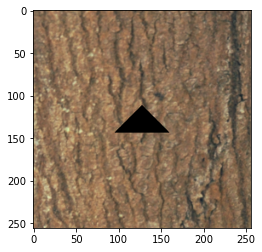

In [32]:
plt.imshow(fake_batch[0])

# (E) Training

In [ ]:
camo_dcgan = CAMO_DCGAN()
camo_dcgan.train(train_steps=ts, batch_size=bs, save_interval=si)